In [1]:
%env TOKENIZERS_PARALLELISM=true
! pip install sentence-transformers

env: TOKENIZERS_PARALLELISM=true
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d0b0ed3efd800cf8a4ae0bbb871eb2908fdd15b7e3df1900cf4a8b986f91ab73
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/alpaca-instructions-word-level-classification/train.csv')
df['instruction length'] = df['instruction'].str.len()
df['text length'] = df['text'].str.len()
df = df.sample(frac=0.2, random_state=2023) # we need a sample for performance reasons
df.head()

,input,instruction,text,output,instruction length,text length
43781,let rows = 5;\nlet cols = 4;\nlet multiArray =...,Optimize the following JavaScript program to r...,Below is an instruction that describes a task....,let rows = 5;\nlet cols = 4;\nlet newRow = new...,77,670
72674,NaN,Create a HTML page to display a list of countr...,Below is an instruction that describes a task....,<!DOCTYPE html>\n<html>\n <head>\n <title>...,77,588
74017,"words = [""apple"", ""blueberry"", ""cat"", ""ant"", ""...",Create a python script to sort an array of wor...,Below is an instruction that describes a task....,"words = [""apple"", ""ant"", ""banana"", ""blueberry""...",120,838
12248,"[5, 3, 2, 9, 1]",Generate a Java method to find the min and max...,Below is an instruction that describes a task....,public static int[] minMax(int[] array) {\n ...,104,583
55141,"[3, 5, 1, 8, 11]",Can you create a sorting algorithm to sort a g...,Below is an instruction that describes a task....,def sort_array(arr):\n sorted_array = arr[:...,57,563


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24392 entries, 43781 to 105015
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   input               17227 non-null  object
 1   instruction         24392 non-null  object
 2   text                24392 non-null  object
 3   output              24390 non-null  object
 4   instruction length  24392 non-null  int64 
 5   text length         24392 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.3+ MB


In [4]:
df.nunique()

input                 11206
instruction           24374
text                  24391
output                24280
instruction length      404
text length            2053
dtype: int64

In [5]:
from plotly.express import histogram
for column in [item for item in df.columns if item.endswith('length')]:
    histogram(data_frame=df, x=column, log_y=True).show()

In [6]:
from plotly.express import scatter
scatter(data_frame=df, x='text length', y='instruction length', log_x=True, log_y=True)

(-0.5, 1199.5, 1199.5, -0.5)

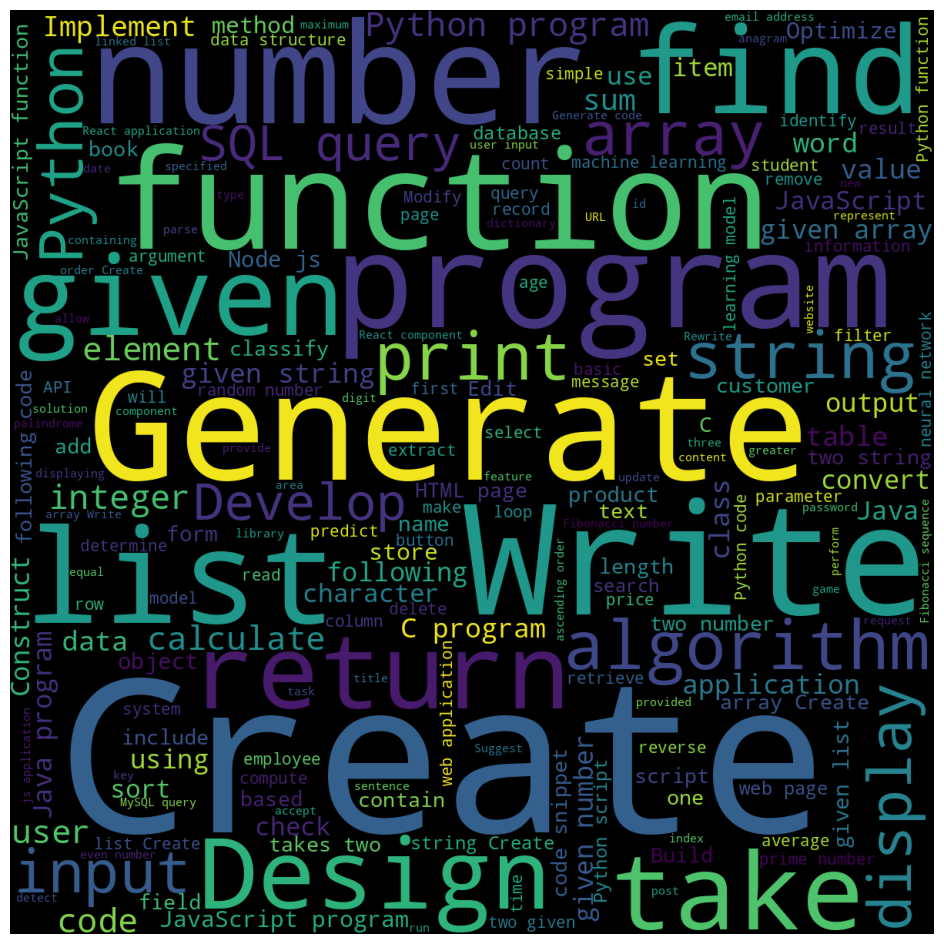

In [7]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 1.0
subplots(figsize=(12, 12))
text = ' '.join(df.sample(frac=FRACTION, random_state=2023)['instruction'].values.tolist())
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=STOPWORDS,).generate(text=text), )
axis('off')

In [8]:
# https://www.kaggle.com/code/ianalyticsgeek/keywords-extraction-using-bert
from arrow import now
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# we can't use more features than we can visualize
MAX_FEATURES = 300

NGRAM_RANGE = (2, 2)
model_start = now()
count = TfidfVectorizer(ngram_range=NGRAM_RANGE, stop_words='english', max_features=MAX_FEATURES, ).fit(df['instruction'])
features = count.get_feature_names_out()
print('{}: got {} features'.format(now(), len(features)))
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
print('{}: built model'.format(now()))
# we need to encode the essays to get the words' relationships to each other
embedding = model.encode(df['instruction'].values.tolist())
print('{}: got embeddings'.format(now()))
feature_embeddings = model.encode(features)
print('{}: got feature embeddings'.format(now()))
print('model time: {}'.format(now() - model_start))

2023-12-04T18:13:17.875161+00:00: got 300 features


2023-12-04T18:13:24.264585+00:00: built model


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

2023-12-04T18:22:26.980366+00:00: got embeddings


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2023-12-04T18:22:29.422658+00:00: got feature embeddings
model time: 0:09:12.545560


In [9]:
# now we can project the feature vectors into 2-space to visualize 
from pandas import DataFrame
from plotly.express import scatter
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=2023, verbose=1, n_iter=10000)
tsne_df = DataFrame(data=tsne.fit_transform(X=feature_embeddings), columns=['t0', 't1'])
tsne_df['word'] = features
tsne_df['score'] = count.transform(features).toarray().sum(axis=0)
scatter(data_frame=tsne_df, x='t0', y='t1', text='word', hover_data=['score'], height=900, ).update_traces(marker={'size': 1})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 178.815948
[t-SNE] KL divergence after 1400 iterations: 4.386711
